In [2]:
import numpy as np
from pathlib import Path
import sys
import tqdm as tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from functions import *

In [3]:
tsv_foldder = "/home/photon/CFG-course_project/projectData"
fasta_files = "/home/photon/CFG-course_project/fasta_outputs"

In [3]:
# lets extract bound and unbound info for a given TF

tsv_file = Path("/home/photon/CFG-course_project/projectData/chr1_200bp_bins.tsv")
tf = 1
TF_indexes = [3,4,5,6]
TF_idx = TF_indexes[tf]

with open(tsv_file, "r") as f:
    next(f, None)
    binding_info = []
    for l in f:
        elements = l.split('\t')
        u_b_string = "".join(elements[TF_idx])
        binding_info.append(u_b_string.strip())
        # print(u_b_string)
    
print("size of the list", sys.getsizeof(binding_info)*1e-6, "mb")
# print(binding_info[:8])
binding_info = np.array(binding_info)
binding_info_dict = {'U': np.where(binding_info == 'U')[0], 'B': np.where(binding_info == 'B')[0]}

print(binding_info_dict)

size of the list 2.926776 mb
{'U': array([     0,      1,      2, ..., 347176, 347177, 347178],
      shape=(340743,)), 'B': array([   871,    872,   1063, ..., 347077, 347093, 347153], shape=(6436,))}


In [4]:
# all mini sequences of length m from which we can transition from where m is the order of our markov model
m = 1
chars = ['A', 'T', 'G', 'C']
possible_combinations = []
pseudocount = 1

string_freq1_pos = dict()
for s in combinations_builder(chars, m+1):
    string_freq1_pos[s] = 0

string_freq2_pos = dict()
for s in combinations_builder(chars, m):
    string_freq2_pos[s] = 0

string_freq1_neg = string_freq1_pos.copy()
string_freq2_neg = string_freq2_pos.copy()

print(string_freq1_pos)
print(string_freq1_neg)
print(string_freq2_pos)
print(string_freq2_pos)

{'AA': 0, 'AT': 0, 'AG': 0, 'AC': 0, 'TA': 0, 'TT': 0, 'TG': 0, 'TC': 0, 'GA': 0, 'GT': 0, 'GG': 0, 'GC': 0, 'CA': 0, 'CT': 0, 'CG': 0, 'CC': 0}
{'AA': 0, 'AT': 0, 'AG': 0, 'AC': 0, 'TA': 0, 'TT': 0, 'TG': 0, 'TC': 0, 'GA': 0, 'GT': 0, 'GG': 0, 'GC': 0, 'CA': 0, 'CT': 0, 'CG': 0, 'CC': 0}
{'A': 0, 'T': 0, 'G': 0, 'C': 0}
{'A': 0, 'T': 0, 'G': 0, 'C': 0}


Area Under Curve (AUC): 0.7596


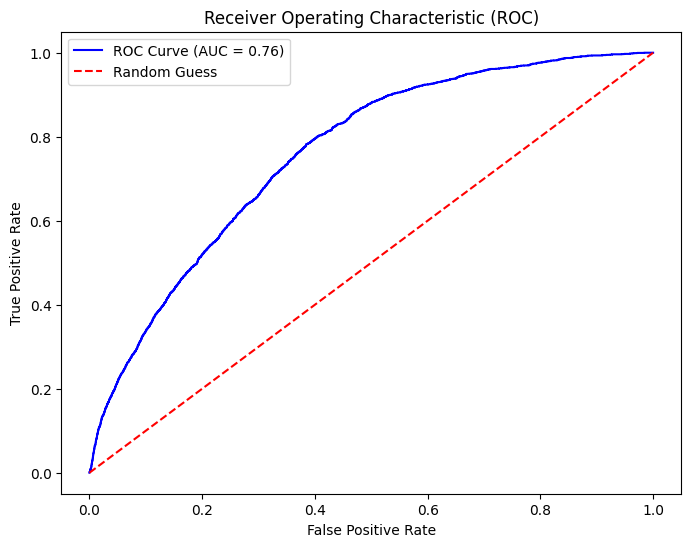

In [ ]:
# k-cross validation
fasta_file = Path(f"/home/photon/CFG-course_project/fasta_outputs/{tsv_file.stem}.fa")

string_freq1_pos = dict()
for s in combinations_builder(chars, m+1):
    string_freq1_pos[s] = 0

string_freq2_pos = dict()
for s in combinations_builder(chars, m):
    string_freq2_pos[s] = 0

string_freq1_neg = string_freq1_pos.copy()
string_freq2_neg = string_freq2_pos.copy()

k = 3

U_idx = binding_info_dict['U']
B_idx = binding_info_dict['B']

# lets split the lists to k equal parts
U_split = np.array_split(U_idx, k)
B_split = np.array_split(B_idx, k)        

for i in range(k):
    # i = 0
    train_indices = [j for j in range(k) if j != i]
    # print(train_indices)
    train_block_pos = np.concatenate([B_split[l] for l in train_indices])
    train_block_neg = np.concatenate([U_split[l] for l in train_indices])
    test_block_pos = B_split[i]
    test_block_neg = U_split[i]
    # print(test_block_neg)
    # training part
    log_likelihood_scores = []

    with open(fasta_file, 'r') as ff :
        for j, l in enumerate(ff) :
            if l.startswith('>'):
                continue
            seq_idx = int((j-1)/2)
            sequence = l.strip()
            # print(seq_idx, sequence)
            if seq_idx in train_block_pos:
                populate_dict(string_freq1_pos, sequence, m, pseudocount)
                populate_dict(string_freq2_pos, sequence, m-1, pseudocount)
            elif seq_idx in train_block_neg:
                # print(seq_idx, sequence)
                populate_dict(string_freq1_neg, sequence, m, pseudocount)
                populate_dict(string_freq2_neg, sequence, m-1, pseudocount)
        # print(string_freq2_neg)
        # print(string_freq1_neg)
        tm_pos = markov_model(string_freq1_pos, string_freq2_pos, chars)
        tm_neg = markov_model(string_freq1_neg, string_freq2_neg, chars)
        # print(tm_pos)
        # print(tm_neg)
    log_likelihood_scores = []
    y_true = []
    ll_pos_bits = []
    ll_neg_bits = []
    with open(fasta_file, 'r') as ff :    
        for j, l in enumerate(ff) :
            if l.startswith('>'):
                continue
            seq_idx = int((j-1)/2)
            sequence = l.strip()
            seq_len = len(sequence)
            if seq_idx in test_block_pos or seq_idx in test_block_neg:
                ll_pos = log_likelihood(tm_pos, string_freq2_pos, chars, sequence, m)
                ll_pos_bits.append(ll_pos/seq_len)
                ll_neg = log_likelihood(tm_neg, string_freq2_neg, chars, sequence, m)
                ll_neg_bits.append(ll_neg/seq_len)
                score = float(ll_pos) - float(ll_neg)
                # print(score)
                log_likelihood_scores.append(score)

                if seq_idx in test_block_pos:
                    y_true.append(1)
                else:
                    y_true.append(0)
            
        fpr, tpr, thresholds = roc_curve(y_true, log_likelihood_scores)
        auc_value = roc_auc_score(y_true, log_likelihood_scores)
        print(f"Area Under Curve (AUC): {auc_value:.4f}")
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_value:.2f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess') # Diagonal line
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend()
        plt.show()
# print(np.array(log_likelihood_scores))



In [ ]:
log_likelihood_scores = []
y_true = []
ll_pos_bits = []
ll_neg_bits = []
with open(fasta_file, 'r') as ff :    
    for j, l in enumerate(ff) :
        if l.startswith('>'):
            continue
        seq_idx = int((j-1)/2)
        sequence = l.strip()
        seq_len = len(sequence)
        if seq_idx in test_block_pos or seq_idx in test_block_neg:
            ll_pos = log_likelihood(tm_pos, string_freq2_pos, chars, sequence, m)
            ll_pos_bits.append(ll_pos/seq_len)
            ll_neg = log_likelihood(tm_neg, string_freq2_neg, chars, sequence, m)
            ll_neg_bits.append(ll_neg/seq_len)
            score = float(ll_pos) - float(ll_neg)
            # print(score)
            log_likelihood_scores.append(score)

            if seq_idx in test_block_pos:
                y_true.append(1)
            else:
                y_true.append(0)
                
    print(np.array(log_likelihood_scores))

    fpr, tpr, thresholds = roc_curve(y_true, log_likelihood_scores)
    auc_value = roc_auc_score(y_true, log_likelihood_scores)
    print(f"Area Under Curve (AUC): {auc_value:.4f}")
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='red', linestyle='--', label='Random Guess') # Diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend()
plt.show()

[ -2.01410604  -3.10033678 -12.48584276 ...   3.89628994   2.4843129
   3.18193161]


115727


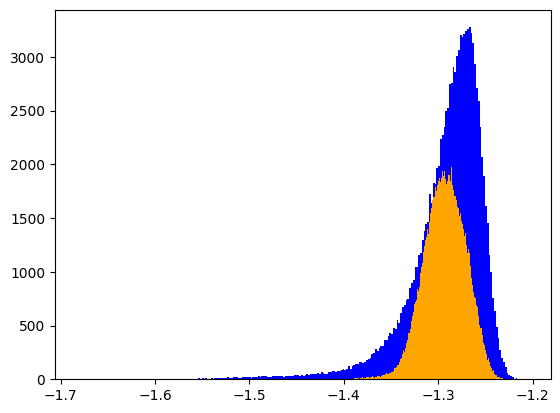

In [77]:
import matplotlib.pyplot as plt
print(len(log_likelihood_scores))
plt.hist(ll_pos_bits, bins = 250, color='blue')
plt.hist(ll_neg_bits, bins = 250, color='orange')
plt.show()